<a href="https://colab.research.google.com/github/NightMachinary/soal_playground/blob/master/soalpy_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


# bootstrap

In [2]:
!sudo apt-get install -y zsh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  zsh-common
Suggested packages:
  zsh-doc
The following NEW packages will be installed:
  zsh zsh-common
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,066 kB of archives.
After this operation, 15.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 zsh-common all 5.4.2-3ubuntu3.1 [3,376 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 zsh amd64 5.4.2-3ubuntu3.1 [690 kB]
Fetched 4,066 kB in 3s (1,485 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend re

In [3]:
%%bash
pip install -U brish

In [4]:
%%script zsh
code_dir='/content/code'
mkdir -p "$code_dir"
cd "$code_dir" 
if test -e soal_playground ; then
  cd soal_playground
  git pull origin master
  pip install --no-deps --force-reinstall ./soalpy
else
  git clone https://github.com/NightMachinary/soal_playground
  cd soal_playground
fi

Cloning into 'soal_playground'...


In [5]:
%%script zsh
code_dir='/content/code'
cd "${code_dir}/soal_playground"
##
ls

benchmarks
data
dimension reduction.org
evaluations
implementations
LICENSE
logs
readme.org
requirements.txt
sk_playground.ipynb
soalpy
src_bash
src_py
src_zsh
tutorials.org


In [6]:
%%script zsh
code_dir='/content/code'
cd "${code_dir}/soal_playground" 
##
rm ./soalpy/setup.py || true
bash ./src_bash/init.bash
zsh ./src_zsh/init.zsh
source ~/.zshenv
rehash
echo "python: $(which python)"
pip install ./soalpy

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-21ubuntu1.1).
zsh is already the newest version (5.4.2-3ubuntu3.1).
The following additional packages will be installed:
  libc-ares2
Suggested packages:
  strace
The following NEW packages will be installed:
  aria2 htop libc-ares2 ncdu time
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,419 kB of archives.
After this operation, 5,306 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 time amd64 1.7-25.1build1 [26.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libc-ares2 amd64 1.14.0-1ubuntu0.1 [37.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 aria2 amd64 1.33.1-1 [1,236 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 htop amd64 2.1.0-3 [80.0 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 ncdu amd64 1.12-1 [38.6

rm: cannot remove './soalpy/setup.py': No such file or directory
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
--2022-01-21 12:24:02--  https://github.com/sharkdp/hyperfine/releases/download/v1.12.0/hyperfine_1.12.0_amd64.deb
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/117356231/ee5d6b99-b790-4751-a7d1-f71e0f0c4e73?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=AKIAIWNJYAX4CSVEH

# benchmarks

In [24]:
%%script zsh
code_dir='/content/code'
cd "${code_dir}/soal_playground" 
##
alias gq=gquote
gquote () {
    print -r -- "${(q+@)@[1]}" "${(qq@)@[2,-1]}"
}
##
function benchmark {
    local name="${1}" ; shift || return $?
    local n="${benchmark_n:-3}"
    local cmd
    cmd=("${@}")

    local cmd_q
    cmd_q="$(gq "${cmd[@]}")"

    # name="${cmd_q}"
    # name="$(echo "$name" | tr "/'\" " '.++=')" || return $?
    
    local dest_dir
    dest_dir="${name}"
    rm -rf -- "$dest_dir" >&/dev/null
    mkdir -p "$dest_dir"
    local time_dest="${dest_dir}/time_stats"

    local time_fmt
    # time_fmt="%MKB %E"
    # time_fmt="%C\nMeasurements: %M,%e"
    time_fmt="%M,%e"

    local i
    local stdout
    local stderr
    for i in {1..${n}} ; do
        # stdout="$(mktemp)" || return $?
        stdout="${dest_dir}/out"
        # typeset -p stdout

        # stderr="$(mktemp)" || return $?
        stderr="${dest_dir}/err"
        echo '##' >> "$stderr" || return $?

        local r=0
        DEBUGME='' random_state="$i" command timeout 2h time -f "$time_fmt" zsh -fc "${cmd_q} >> ${stdout} 2>> ${stderr}" 2>> "$time_dest" || r=$?
        if [[ "$r" == 124 ]] ; then
            echo "timeout error"
        elif [[ "$r" != 0 ]] ; then
            echo "command failed with $r"
        fi

        ##
        # rm -f "$stdout" || true
        # rm -f "$stderr" || true
        ##
    done
}
##
cd src_py

local bench_dir="/content/drive/MyDrive/soalpy/benchmarks"
local data_gen_dir="/content/data_gen"

local algo_families='kmeans'
local algos_kmeans=(
  'nop'

  'kmeans_cuml_n10_iter10e4'

  'kmeans_mb2e7_sklearn_n10_iter10e4'
  'kmeans_mb2e10_sklearn_n10_iter10e4'
  'kmeans_mb2e13_sklearn_n10_iter10e4'
  
  'kmeans_b3_sklearn_n10_iter10e4'

  'kmeans_sklearn_n10_iter10e4'

  'kmeans_sklearn_full_n10_iter10e4'
  )
# algos_kmeans=('nop')
##
local datasets=(
  'blobs_10e4_10e4'
  'blobs_10e5_10e4'
  'blobs_10e4_10e5'
  )

function blobs_gen {
  local name="${1:?}" algo="${2:?}"

  local save_p=y
  if test -z "$save_p" ; then
    benchmark "$name" python run_one.py "$algo" "${blobs_opts[@]}"
  else
    local save_dir
    save_dir="${data_gen_dir}/${dataset_name:?}"

    run_one_save_dir="$save_dir" \
      python run_one.py "save" "${blobs_opts[@]}"

    run_one_load_dir="$save_dir" \
      benchmark "$name" python run_one.py "$algo" "${blobs_opts[@]}"
  fi
}
function blobs_10e4_10e4 {
  blobs_opts=(10_000 10_000) blobs_gen "$@"
}
function blobs_10e5_10e4 {
  blobs_opts=(100_000 10_000) blobs_gen "$@"
}
function blobs_10e4_10e5 {
  blobs_opts=(10_000 100_000) blobs_gen "$@"
}
##
local ds algo_family algo_family_var algo current_dir
for ds in ${datasets[@]}; do
  echo "####### Dataset: ${ds}"
  for algo_family in ${algo_families[@]} ; do
    echo "###### Algorithm Family: ${algo_family}"
    algo_family_var="algos_${algo_family}"
    local algos=(${(@P)algo_family_var})
    for algo in ${algos[@]}; do
      echo "##### Algorithm: ${algo}"
      current_dir="${bench_dir}/${ds}/${algo_family}/${algo}"
      dataset_name="${ds}" "${ds}" "$current_dir" "$algo"

      echo "#### stats:"
      cat "${current_dir}/time_stats"
      echo "#### out:"
      cat "${current_dir}/out"
      if test -s "${current_dir}/err" ; then
        echo "#### err:"
        cat "${current_dir}/err" | egrep -v '^\s*tcmalloc: large alloc'
      fi
    done
  done
done

####### Dataset: blobs_10e4_10e4
###### Algorithm Family: kmeans
##### Algorithm: nop
#### stats:
617688,3.74
621960,3.68
617096,3.68
#### out:
#### err:
##
Loading the data from: /content/data_gen/blobs_10e4_10e4
##
Loading the data from: /content/data_gen/blobs_10e4_10e4
##
Loading the data from: /content/data_gen/blobs_10e4_10e4
##### Algorithm: kmeans_cuml_n10_iter10e4
#### stats:
2912324,8.34
2924864,8.51
2910896,8.18
#### out:
99914576.0,1.0,1.0,1.0
99914576.0,1.0,1.0,1.0
99914576.0,1.0,1.0,1.0
#### err:
##
Loading the data from: /content/data_gen/blobs_10e4_10e4
##
Loading the data from: /content/data_gen/blobs_10e4_10e4
##
Loading the data from: /content/data_gen/blobs_10e4_10e4
##### Algorithm: kmeans_mb2e7_sklearn_n10_iter10e4
#### stats:
989448,5.03
993060,5.39
993008,5.25
#### out:
99949920.0,1.0,1.0,1.0
99946416.0,1.0,1.0,1.0
99944192.0,1.0,1.0,1.0
#### err:
##
Loading the data from: /content/data_gen/blobs_10e4_10e4
##
Loading the data from: /content/data_gen/blobs_10e4_1

skipped saving the dataset
skipped saving the dataset
skipped saving the dataset
skipped saving the dataset
skipped saving the dataset
skipped saving the dataset
skipped saving the dataset
tcmalloc: large alloc 8000004096 bytes == 0x55b68ae5a000 @  0x7fa20e4a81e7 0x7fa20cb1549e 0x7fa20cb15534 0x7fa20cb59565 0x7fa20cbf5512 0x7fa20cbf5c9f 0x7fa20cbf5e12 0x55b4a52bc578 0x7fa20cb45f2c 0x55b4a51ea9b9 0x55b4a51edebe 0x55b4a528f5d6 0x55b4a5271433 0x55b4a5272818 0x55b4a528f3c3 0x55b4a5271433 0x55b4a5272818 0x55b4a51dcb6e 0x55b4a528c84f 0x55b4a5271433 0x55b4a5272499 0x55b4a530decb 0x55b4a530df63 0x55b4a532a033 0x55b4a532f022 0x55b4a532f202 0x55b4a532f77d 0x55b4a532f939 0x7fa20d4d9bf7 0x55b4a52a3f39
tcmalloc: large alloc 8000004096 bytes == 0x55b8683c0000 @  0x7fa20e4a81e7 0x7fa20cb1549e 0x7fa20cb15534 0x7fa20cb59565 0x7fa20cb59718 0x7fa20cbe151e 0x7fa20cbe1fd8 0x55b4a5240255 0x55b4a528b3e3 0x55b4a5271433 0x55b4a5272818 0x55b4a51dcb6e 0x55b4a528c84f 0x55b4a5271433 0x55b4a5272499 0x55b4a530decb 0

In [8]:
%%script zsh
cat /content/nvidia.log  | grep '16280MiB' | egrep -v '\s(2|0)MiB' 

#: max memory usage seems to be 12261MiB / 16280MiB

cat: /content/nvidia.log: No such file or directory


In [9]:
%%script zsh
local bench_dir="/content/drive/MyDrive/soalpy/benchmarks"

cd "${bench_dir}"
ls */*

blobs_10e4_10e4/kmeans:
kmeans_b3_sklearn_n10_iter10e4
kmeans_cuml_n10_iter10e4
kmeans_mb2e10_sklearn_n10_iter10e4
kmeans_mb2e13_sklearn_n10_iter10e4
kmeans_mb2e7_sklearn_n10_iter10e4
kmeans_sklearn_full_n10_iter10e4
kmeans_sklearn_n10_iter10e4
nop

blobs_10e4_10e5/kmeans:
kmeans_b3_sklearn_n10_iter10e4
kmeans_cuml_n10_iter10e4
kmeans_mb2e10_sklearn_n10_iter10e4
kmeans_mb2e13_sklearn_n10_iter10e4
kmeans_mb2e7_sklearn_n10_iter10e4
kmeans_sklearn_full_n10_iter10e4
kmeans_sklearn_n10_iter10e4
nop

blobs_10e5_10e4/kmeans:
kmeans_b3_sklearn_n10_iter10e4
kmeans_cuml_n10_iter10e4
kmeans_mb2e10_sklearn_n10_iter10e4
kmeans_mb2e13_sklearn_n10_iter10e4
kmeans_mb2e7_sklearn_n10_iter10e4
kmeans_sklearn_full_n10_iter10e4
kmeans_sklearn_n10_iter10e4
nop


## plots

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 15,8.27

In [26]:
import pandas
pd = pandas
import numpy
np = numpy
from glob import glob
from fnmatch import fnmatch

bench_dir="/content/drive/MyDrive/soalpy/benchmarks"


datasets = glob(f"{bench_dir}/*")
datasets

['/content/drive/MyDrive/soalpy/benchmarks/blobs_10e4_10e4',
 '/content/drive/MyDrive/soalpy/benchmarks/blobs_10e5_10e4',
 '/content/drive/MyDrive/soalpy/benchmarks/blobs_10e4_10e5']

In [31]:
d = pd.DataFrame()

for ds in datasets:
  algos = glob(f"{ds}/*/*")
  # print(algos)

  for algo in algos:
    stats = pd.read_csv(f"{algo}/time_stats", names=['max_memory', 'time'])
    out = pd.read_csv(f"{algo}/out", 
                      names=['loss',
                             'homogeneity_score', 
                             'completeness_score',
                             'adjusted_rand_score',
                             ])
    stats = stats.join(out)
    stats['algo'] = algo.split('/')[-1]
    stats['dataset'] = ds.split('/')[-1]
    d = pd.concat([d, stats])

with pd.option_context(
    'display.max_colwidth', None,
    'max_rows', None,):
  display(d)

,max_memory,time,loss,homogeneity_score,completeness_score,adjusted_rand_score,algo,dataset
0,617688,3.74,NaN,NaN,NaN,NaN,nop,blobs_10e4_10e4
1,621960,3.68,NaN,NaN,NaN,NaN,nop,blobs_10e4_10e4
2,617096,3.68,NaN,NaN,NaN,NaN,nop,blobs_10e4_10e4
0,2912324,8.34,99914576.0,1.0,1.0,1.0,kmeans_cuml_n10_iter10e4,blobs_10e4_10e4
1,2924864,8.51,99914576.0,1.0,1.0,1.0,kmeans_cuml_n10_iter10e4,blobs_10e4_10e4
2,2910896,8.18,99914576.0,1.0,1.0,1.0,kmeans_cuml_n10_iter10e4,blobs_10e4_10e4
0,989448,5.03,99949920.0,1.0,1.0,1.0,kmeans_mb2e7_sklearn_n10_iter10e4,blobs_10e4_10e4
1,993060,5.39,99946416.0,1.0,1.0,1.0,kmeans_mb2e7_sklearn_n10_iter10e4,blobs_10e4_10e4
2,993008,5.25,99944192.0,1.0,1.0,1.0,kmeans_mb2e7_sklearn_n10_iter10e4,blobs_10e4_10e4
0,1216672,7.75,99934048.0,1.0,1.0,1.0,kmeans_mb2e10_sklearn_n10_iter10e4,blobs_10e4_10e4


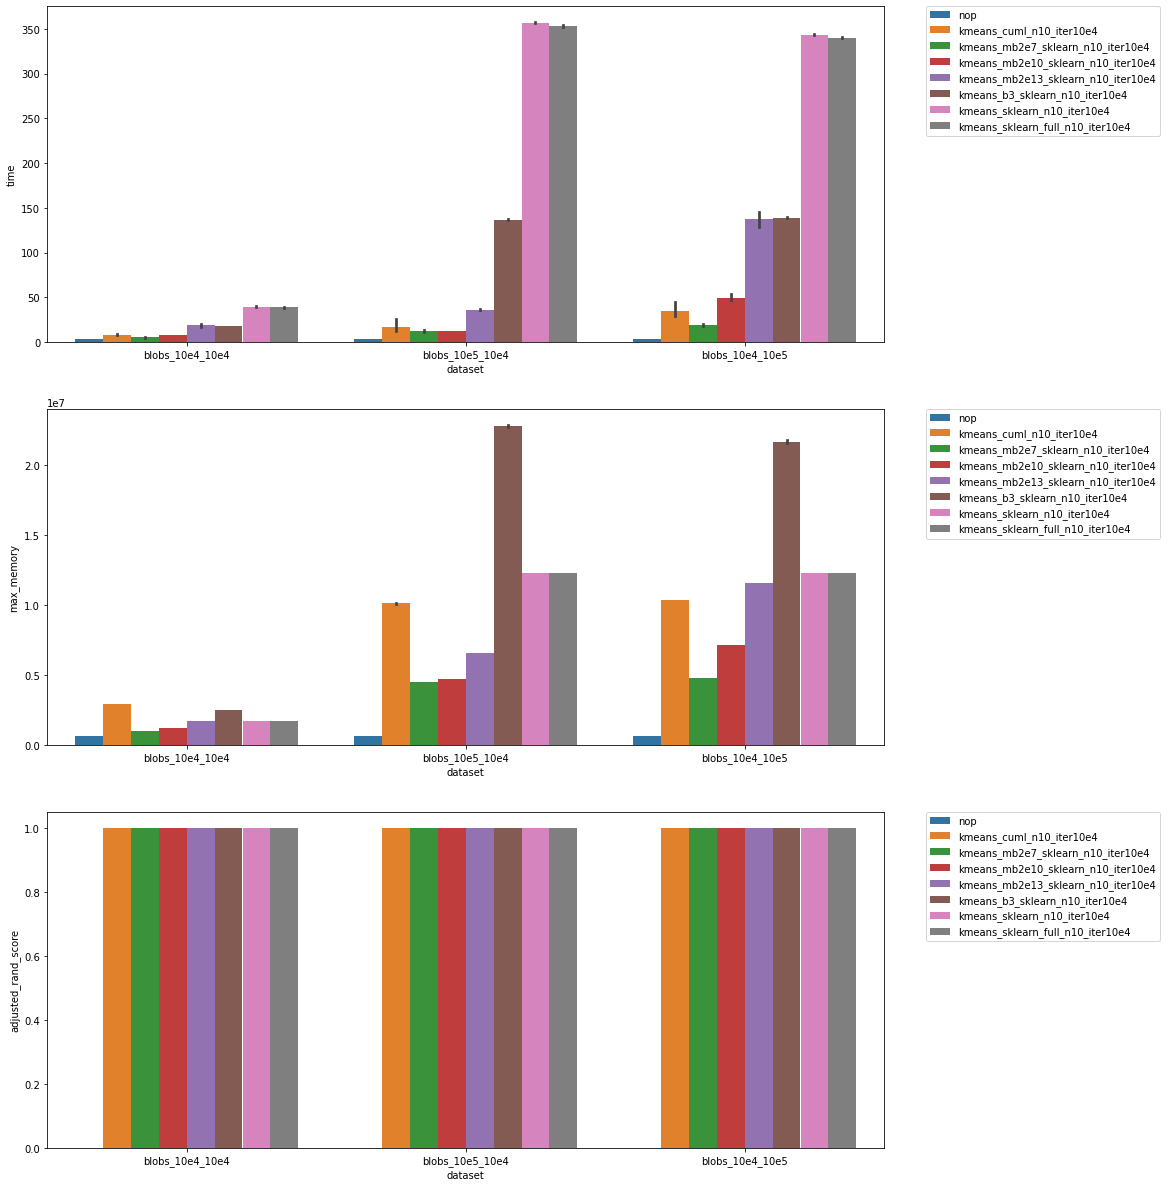

In [28]:
ys = ['time', 'max_memory', 'adjusted_rand_score']
fig, axs = plt.subplots(
    # ncols=len(ys),
    ##
    nrows=len(ys),
    figsize=(15,7*(len(ys)))
    )
for i, y in enumerate(ys):
  ax = sns.barplot(
      x='dataset',
      hue='algo',
      y=y,
      data=d,
      ax=axs[i]
  )
  if True or (i == (len(ys) - 1)):
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  else:
    ax.get_legend().remove()
  # display(ax)

# display(fig)
None

# tmp

In [18]:
%%script zsh
code_dir='/content/code'
cd "${code_dir}/soal_playground" 
##
git pull origin master
cd src_py

echo '#############'
cat run_one.py
echo '#############'

# command time -f '%M' python run_one.py nop 10_000 10_000
command time -f '%M' python run_one.py nop_float64 10_000 10_000

Updating 8b60705..70b5313
Fast-forward
 implementations/DL/autoencoders/gen.org | 3 +++
 src_py/run_one.py                       | 2 +-
 2 files changed, 4 insertions(+), 1 deletion(-)
#############
#!/usr/bin/env python

import sys
import os
import gc
from soalpy.utils import *
from soalpy.kmeans_runners import *
from pynight.common_iterable import get_or_none
from pynight.common_debugging import debug_p
from pynight.common_files import dir_ensure

def nop(*args, **kwargs):
    return None
nop_float64 = nop

def save(X, y, **kwargs):
    #: * https://numpy.org/doc/stable/reference/generated/numpy.save.html
    ##
    save_dir = get_or_none(os.environ, "run_one_save_dir") #: @input
    assert save_dir

    X_path = f"{save_dir}/X.npy"
    if os.path.exists(X_path):
        #: Don't recreate the datasets if they already exist.
        print("skipped saving the dataset", file=sys.stderr)
        return None

    dir_ensure(f"{save_dir}/")
    np.save(X_path, X, allow_pickle=False)
    np

From https://github.com/NightMachinary/soal_playground
 * branch            master     -> FETCH_HEAD
   8b60705..70b5313  master     -> origin/master
skipped converting the data to float32
2185800


In [15]:
%%script zsh

command time -f 'Max memory: %M KB' python -c '
import sklearn
sklearn.show_versions()
from sklearn import datasets

blobs_opts = {
    "n_samples": 10**4,
    "n_features": 10**4,
    "centers": 10,
    "random_state": 10
}
X, y = datasets.make_blobs(**blobs_opts)
None
'


System:
    python: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05)  [GCC 9.3.0]
executable: /root/miniconda3/bin/python
   machine: Linux-5.4.144+-x86_64-with-glibc2.10

Python dependencies:
          pip: 21.3.1
   setuptools: 59.8.0
      sklearn: 1.0.2
        numpy: 1.21.5
        scipy: 1.7.3
       Cython: None
       pandas: 1.3.5
   matplotlib: 3.4.3
       joblib: 1.1.0
threadpoolctl: 3.0.0

Built with OpenMP: True


Max memory: 1708040 KB


In [16]:
%%script zsh

command time -f '%M' python -c '
from cuml.dask import datasets

blobs_opts = {
    "n_samples": 10**4,
    "n_features": 10**4,
    "centers": 10,
    "random_state": 10
}
X, y = datasets.make_blobs(**blobs_opts)
None
'

Traceback (most recent call last):
  File "<string>", line 10, in <module>
  File "/root/miniconda3/lib/python3.8/site-packages/cuml/common/memory_utils.py", line 93, in cupy_rmm_wrapper
    return func(*args, **kwargs)
  File "/root/miniconda3/lib/python3.8/site-packages/cuml/dask/datasets/blobs.py", line 107, in make_blobs
    client = get_client(client=client)
  File "/root/miniconda3/lib/python3.8/site-packages/cuml/dask/common/utils.py", line 88, in get_client
    return default_client() if client is None else client
  File "/root/miniconda3/lib/python3.8/site-packages/distributed/client.py", line 4763, in default_client
    raise ValueError(
ValueError: No clients found
Start a client and point it to the scheduler address
  from distributed import Client
  client = Client('ip-addr-of-scheduler:8786')

Command exited with non-zero status 1
381952
